# Private Neural Portraits
This Jupyter notebook will allow you to create artistically styled portraits that can evade face detection models. 
## Preparing the Paint Transformer
The paint transformer artistically styles natural images.

In [29]:
!git clone https://github.com/NeverGiveU/PaintTransformer-Pytorch-master paint
!git clone https://github.com/enderminyard/lowkey.git 
!pip install /content/lowkey/requirements.txt
!rm paint/samples/inputs/bingbing.jpg 
%cd /content/paint


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/content/paint


## Preparing Your Selfie

You can upload any image of yourself that you want to obfuscate.

In [4]:
# uploading images to Colab without Google Drive
from PIL import Image  
import PIL  
import numpy as np
import urllib
import cv2
import urllib.request
def url_to_image(url):
	resp = urllib.request.urlopen(url)
	image = np.asarray(bytearray(resp.read()), dtype="uint8")
	image = cv2.imdecode(image, cv2.IMREAD_COLOR)
	return image

your_url = "https://upload.wikimedia.org/wikipedia/commons/8/89/Solange_%28220707%29.jpg" #Change this url to your selfie!

img = url_to_image(your_url)
image = Image.fromarray(img)
image = image.save("/content/paint/samples/inputs/darling.jpg")


dataset.py	   network.py	      __pycache__  samples
inference.py	   paddle2pytorch.py  README.md    stroke_renderer.py
network_paddle.py  paint_best.pth     render	   test_convertor.py


## Painting Your Private Neural Portrait

First, we use [Fawkes](https://arxiv.org/abs/2002.08327v2) and [LowKey](https://arxiv.org/abs/2101.07922) to keep your face from being correctly labeled by face detection models. 

Then, we take your selfie and turn it into an artistic portrait so that [adversarial defenses like super-resolution](https://arxiv.org/abs/1901.01677) cannot restore the original version of your selfie that could be correctly labeled.

In [7]:
!fawkes -d /content/paint/samples/inputs/ --mode high

2022-09-25 18:19:24.763128: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-09-25 18:19:26.998562: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-09-25 18:19:26.999816: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-09-25 18:19:27.010634: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-09-25 18:19:27.010696: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (d603b24d0fbc): /proc/driver/nvidia/version does not exist
2022-09-25 18:19:27.156201: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in perfo

In [ ]:
import torch
import PIL
from PIL import Image
import numpy as np
from lowkey.util.feature_extraction_utils import feature_extractor, normalize_transforms, warp_image, normalize_batch
from lowkey.backbone.model_irse import IR_50, IR_101, IR_152
from lowkey.backbone.model_resnet import ResNet_50, ResNet_101, ResNet_152
from lowkey.util.attack_utils import  Attack
from lowkey.util.prepare_utils import prepare_models, prepare_dir_vec, get_ensemble, prepare_data
from lowkey.align.detector import detect_faces
from lowkey.align.align_trans import get_reference_facial_points, warp_and_crop_face
import matplotlib.pyplot as plt
import copy
import torchvision.transforms as transforms
import sys, os


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
to_tensor = transforms.ToTensor()

# Disable
def blockPrint():
    sys.stdout = open(os.devnull, 'w')

def enablePrint():
    sys.stdout = sys.__stdout__


eps = 0.05
n_iters = 50
input_size = [112, 112]
attack_type = 'lpips'
c_tv = None
c_sim = 0.05
lr = 0.0025
net_type = 'alex'
noise_size = 0.005
n_starts = 1
kernel_size_gf = 7
sigma_gf = 3
combination = True
using_subspace = False
V_reduction_root = './'
model_backbones = ['IR_152', 'IR_152', 'ResNet_152', 'ResNet_152']
model_roots = ['models/Backbone_IR_152_Arcface_Epoch_112.pth', 'models/Backbone_IR_152_Cosface_Epoch_70.pth', \
 'models/Backbone_ResNet_152_Arcface_Epoch_65.pth', 'models/Backbone_ResNet_152_Cosface_Epoch_68.pth'] 
direction = 1
crop_size = 112
scale = crop_size / 112.

models_attack, V_reduction, dim = prepare_models(model_backbones,
             input_size,
             model_roots,
             kernel_size_gf,
             sigma_gf,
             combination,
             using_subspace,
             V_reduction_root,
             device)



img = Image.open("/content/paint/samples/inputs/darling.jpg").convert("RGB")
img = img.resize((112, 112))

idx = 0
batch_size = 8



reference = get_reference_facial_points(default_square = True) * scale

tensor_img = torch.cat([to_tensor(i).unsqueeze(0) for i in batch], 0).to(device)
print(tensor_img.shape)

V_reduction = None
dim = 512

# find direction vector
dir_vec_extractor = get_ensemble(models = models_attack, sigma_gf = None, kernel_size_gf = None, combination = False, V_reduction = V_reduction, warp = False, theta_warp = None)
dir_vec = prepare_dir_vec(dir_vec_extractor, tensor_img, dim, combination)

img_attacked = tensor_img.clone()
attack = Attack(models_attack, dim, attack_type, eps, c_sim, net_type, lr,
    n_iters, noise_size, n_starts, c_tv, sigma_gf, kernel_size_gf,
    combination, warp=False, theta_warp=None, V_reduction = V_reduction)

img_attacked = attack.execute(tensor_img, dir_vec, direction).detach().cpu()
img_attacked_pil = transforms.ToPILImage()(img)
img_attacked_pil.save("/content/paint/samples/inputs/darling.jpg")


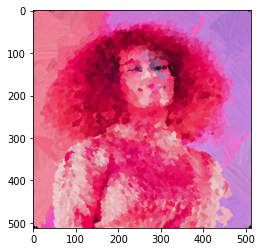

In [32]:
# Paint the corrupted image
!python3 inference.py


# Show the final image
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

img = cv2.imread("/content/paint/samples/outputs/darling/170.png") 
plt.imshow(img)